https://twitter.com/MathSorcerer/status/1302576992965984261

In [1]:
module Goma # 再編集しやすいように仮想モジュールを設定

abstract type AbstractEdge{T<:Integer} end

struct Edge{T} <: AbstractEdge{T}
    data::NTuple{2, T}
    Edge(x::NTuple{2, T}) where T = new{T}(x)
    # To define Edge{Int}(1, 2)
    Edge{T}(x::Vararg{T2, 2}) where {T, T2} = new{T}(NTuple{2, T}(convert.(T, x)))
    # To define Edge{Int}([1, 2])
    Edge{T}(x::AbstractVector{T2}) where {T,T2} = new{T}(NTuple{2, T2}(x))
    # To define Edge{Int}((1,2))
    Edge{T}(x::Tuple) where T = new{T}(NTuple{2, T}(x))
end

function Edge(x::Tuple)
    nt = NTuple(promote(x...))
    if eltype(nt) <: Integer
        Edge(nt)
    else
        try 
            Edge(Int.(nt))
        catch 
            error("Fail to convert $(nt) to NTuple{$(length(nt)), Int}")
        end
    end
end

Edge(v::AbstractVector) = Edge(promote(v...))
Edge(vargs...) = Edge(vargs)

const Right = Edge(1, 0)
const Left  = Edge(-1, 0)
const Up    = Edge(0, 1)
const Down  = Edge(0, -1)

# override functions
Base.getindex(e::AbstractEdge, i::Int) = e.data[i]
Base.iterate(e::AbstractEdge, state=1) = iterate(e.data, state)
Base.length(e::AbstractEdge) = length(e.data)
Base.size(e::AbstractEdge) = (length(e.data),)

function Base.getproperty(e::Edge, sym::Symbol)
    if sym in fieldnames(Edge)
        return getfield(e, sym)
    elseif sym === :x
        return e[1]
    elseif sym === :y
        return e[2]
    else
        error("invalid symbol $sym")
    end
end

function Base.show(io::IO,  mime::MIME"text/plain", e::AbstractEdge{T}) where {T}
    println(io, e |> typeof)
    for (i, (s, d)) in enumerate(zip([:x,:y], e))
        println(io, "$s = $(e[i])")
    end
end

# Define conversion and promotion
Base.promote_rule(a::Type{Edge{T1}}, b::Type{Edge{T2}}) where {T1, T2} = Edge{promote_type(T1, T2)}
Edge{T}(x::Edge{T2}) where {T, T2} = Edge{T}(x.data)
Edge(x::Edge) = x

Base.convert(::Type{Edge{T}}, x::Edge{T2}) where {T, T2} = Edge{T}(x)

# Operation
for op in [:+, :-, :*]
    @eval function Base.$op(e1::AbstractEdge{T1}, e2::AbstractEdge{T2}) where {T1, T2}
        promote_type(typeof(e1), typeof(e2))(broadcast($op, e1.data, e2.data))
    end
end

abstract type AbstractPath{T<:Integer} end

struct Path{T} <: AbstractPath{T}
    edges::Vector{Edge{T}}
    origin::NTuple{2, T}
    Path(edges::Vector{Edge{T}}) where {T} = new{T}(Edge{T}.(edges), NTuple{2, T}(zeros(T , 2)))
    Path{T}(edges::Vector{Edge{T1}}) where {T, T1} = new{T}(Edge{T}.(edges), NTuple{2, T}(zeros(T, 2)))
    Path(edges::Vector{Edge{T1}}, origin::NTuple{2, T2}) where {T1, T2} = new{promote_type(T1, T2)}(edges, origin)
    Path{T}(edges::Vector{Edge{T1}}, origin) where {T, T1} = new{T}(Edge{T}.(edges), NTuple{2, T}(origin))
end

end

Edge = Goma.Edge
Path = Goma.Path

R = Right = Goma.Right
L = Left = Goma.Left
U = Up = Goma.Up
D = Down = Goma.Down;

In [2]:
using Plots

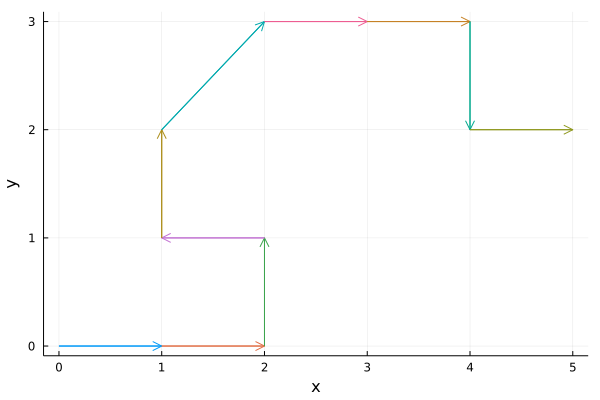

In [3]:
edges = Edge{Int32}.([
        [1,0],
        R,
        U,
        L,
        U,
        [1,1],
        R,
        R,
        [0,-1],
        R,
])

path = Path(edges)

x, y = path.origin
xmin = xmax = x
ymin = ymax = y

p = plot(xlabel="x", ylabel="y")
for e in path.edges
    quiver!(p, [x], [y], quiver=([e.x], [e.y]))
    x += e.x
    y += e.y
    xmin = min(xmin, x + e.x)
    ymin = min(ymin, y + e.y)
    xmax = max(xmax, x + e.x)
    ymax = max(ymax, y + e.y)
end

plot!(p, xticks = xmin:xmax, yticks = ymin:ymax)

p

In [4]:
methods(Goma.Edge)

# 5 methods for type constructor:
[1] Main.Goma.Edge(x::Tuple{T, T}) where T in Main.Goma at In[1]:7
[2] Main.Goma.Edge(x::Tuple) in Main.Goma at In[1]:16
[3] Main.Goma.Edge(v::AbstractVector{T} where T) in Main.Goma at In[1]:29
[4] Main.Goma.Edge(x::Main.Goma.Edge) in Main.Goma at In[1]:65
[5] Main.Goma.Edge(vargs...) in Main.Goma at In[1]:30

In [5]:
module Kuma # 再編集しやすいように仮想モジュールを設定

abstract type AbstractEdge{T<:Integer} end

struct Edge{T} <: AbstractEdge{T}
    data::NTuple{2, T}
    # Automatically defined are
    #   Edge(data::Tuple{T, T}) where T
    #   Edge{T}(data)

#     Edge(x::NTuple{2, T}) where T = new{T}(x)
#     # To define Edge{Int}(1, 2)
#     Edge{T}(x::Vararg{T2, 2}) where {T, T2} = new{T}(NTuple{2, T}(convert.(T, x)))
#     # To define Edge{Int}([1, 2])
#     Edge{T}(x::AbstractVector{T2}) where {T,T2} = new{T}(NTuple{2, T2}(x))
#     # To define Edge{Int}((1,2))
#     Edge{T}(x::Tuple) where T = new{T}(NTuple{2, T}(x))
end

Edge{T}(x, y) where T = Edge{T}((x, y))
Edge{T}(v::AbstractVector) where T = Edge{T}(v...)

function Edge(x::Tuple)
    nt = NTuple(promote(x...))
    if eltype(nt) <: Integer
        Edge(nt)
    else
        try 
            Edge(Int.(nt))
        catch 
            error("Fail to convert $(nt) to NTuple{$(length(nt)), Int}")
        end
    end
end

Edge(x, y) = Edge((x, y))
Edge(v::AbstractVector) = Edge(v...)

const Right = Edge(1, 0)
const Left  = Edge(-1, 0)
const Up    = Edge(0, 1)
const Down  = Edge(0, -1)

# override functions
Base.getindex(e::AbstractEdge, i::Int) = e.data[i]
Base.iterate(e::AbstractEdge, state=1) = iterate(e.data, state)
Base.length(e::AbstractEdge) = length(e.data)
Base.size(e::AbstractEdge) = (length(e.data),)

function Base.getproperty(e::Edge, sym::Symbol)
    if sym in fieldnames(Edge)
        return getfield(e, sym)
    elseif sym === :x
        return e[1]
    elseif sym === :y
        return e[2]
    else
        error("invalid symbol $sym")
    end
end

function Base.show(io::IO,  mime::MIME"text/plain", e::AbstractEdge{T}) where {T}
    println(io, e |> typeof)
    for (i, (s, d)) in enumerate(zip([:x,:y], e))
        println(io, "$s = $(e[i])")
    end
end

# Define conversion and promotion
Base.promote_rule(a::Type{Edge{T1}}, b::Type{Edge{T2}}) where {T1, T2} = Edge{promote_type(T1, T2)}
Edge{T}(x::Edge) where T = Edge{T}(x.data)
Edge(x::Edge) = x

Base.convert(::Type{Edge{T}}, x::Edge{T2}) where {T, T2} = Edge{T}(x)

# Operation
for op in [:+, :-, :*]
    @eval function Base.$op(e1::AbstractEdge{T1}, e2::AbstractEdge{T2}) where {T1, T2}
        promote_type(typeof(e1), typeof(e2))(broadcast($op, e1.data, e2.data))
    end
end

abstract type AbstractPath{T<:Integer} end

struct Path{T} <: AbstractPath{T}
    edges::Vector{Edge{T}}
    origin::NTuple{2, T}
    Path(edges::Vector{Edge{T}}) where {T} = new{T}(Edge{T}.(edges), NTuple{2, T}(zeros(T , 2)))
    Path{T}(edges::Vector{Edge{T1}}) where {T, T1} = new{T}(Edge{T}.(edges), NTuple{2, T}(zeros(T, 2)))
    Path(edges::Vector{Edge{T1}}, origin::NTuple{2, T2}) where {T1, T2} = new{promote_type(T1, T2)}(edges, origin)
    Path{T}(edges::Vector{Edge{T1}}, origin) where {T, T1} = new{T}(Edge{T}.(edges), NTuple{2, T}(origin))
end

end

Edge = Kuma.Edge
Path = Kuma.Path

R = Right = Kuma.Right
L = Left = Kuma.Left
U = Up = Kuma.Up
D = Down = Kuma.Down;

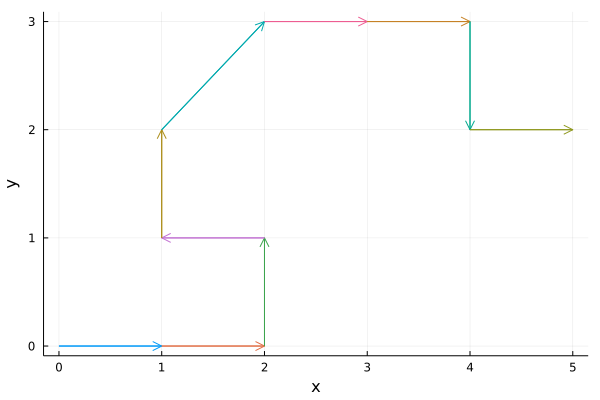

In [6]:
edges = Edge{Int32}.([
        [1,0],
        R,
        U,
        L,
        U,
        [1,1],
        R,
        R,
        [0,-1],
        R,
])

path = Path(edges)

x, y = path.origin
xmin = xmax = x
ymin = ymax = y

p = plot(xlabel="x", ylabel="y")
for e in path.edges
    quiver!(p, [x], [y], quiver=([e.x], [e.y]))
    x += e.x
    y += e.y
    xmin = min(xmin, x + e.x)
    ymin = min(ymin, y + e.y)
    xmax = max(xmax, x + e.x)
    ymax = max(ymax, y + e.y)
end

plot!(p, xticks = xmin:xmax, yticks = ymin:ymax)

p

In [7]:
methods(Kuma.Edge) |> display
methods(Kuma.Edge{Int}) |> display

# 5 methods for type constructor:
[1] Main.Kuma.Edge(data::Tuple{T, T}) where T in Main.Kuma at In[5]:6
[2] Main.Kuma.Edge(x::Tuple) in Main.Kuma at In[5]:23
[3] Main.Kuma.Edge(v::AbstractVector{T} where T) in Main.Kuma at In[5]:37
[4] Main.Kuma.Edge(x::Main.Kuma.Edge) in Main.Kuma at In[5]:72
[5] Main.Kuma.Edge(x, y) in Main.Kuma at In[5]:36

# 4 methods for type constructor:
[1] Main.Kuma.Edge{T}(v::AbstractVector{T} where T) where T in Main.Kuma at In[5]:21
[2] Main.Kuma.Edge{T}(x::Main.Kuma.Edge) where T in Main.Kuma at In[5]:71
[3] Main.Kuma.Edge{T}(data) where T in Main.Kuma at In[5]:6
[4] Main.Kuma.Edge{T}(x, y) where T in Main.Kuma at In[5]:20

In [8]:
methods(Goma.Edge) |> display
methods(Goma.Edge{Int}) |> display

# 5 methods for type constructor:
[1] Main.Goma.Edge(x::Tuple{T, T}) where T in Main.Goma at In[1]:7
[2] Main.Goma.Edge(x::Tuple) in Main.Goma at In[1]:16
[3] Main.Goma.Edge(v::AbstractVector{T} where T) in Main.Goma at In[1]:29
[4] Main.Goma.Edge(x::Main.Goma.Edge) in Main.Goma at In[1]:65
[5] Main.Goma.Edge(vargs...) in Main.Goma at In[1]:30

# 4 methods for type constructor:
[1] Main.Goma.Edge{T}(x::AbstractVector{T2}) where {T, T2} in Main.Goma at In[1]:11
[2] Main.Goma.Edge{T}(x::Tuple) where T in Main.Goma at In[1]:13
[3] Main.Goma.Edge{T}(x::Main.Goma.Edge{T2}) where {T, T2} in Main.Goma at In[1]:64
[4] Main.Goma.Edge{T}(x::Vararg{T2, 2}) where {T, T2} in Main.Goma at In[1]:9

In [9]:
Kuma.Edge{Int}((1.0, 2.0))

Main.Kuma.Edge{Int64}
x = 1
y = 2


In [10]:
@which Kuma.Edge{Int}((1.0, 2.0))

Main.Kuma.Edge{T}(data) where T in Main.Kuma at In[5]:6

In [11]:
Goma.Edge{Int}((1.0, 2.0))

Main.Goma.Edge{Int64}
x = 1
y = 2


In [12]:
@which Goma.Edge{Int}((1, 2))

Main.Goma.Edge{T}(x::Tuple) where T in Main.Goma at In[1]:13

In [13]:
Kuma.Edge{Int}([1.0, 2.0])

Main.Kuma.Edge{Int64}
x = 1
y = 2


In [14]:
@which Kuma.Edge{Int}([1.0, 2.0])

Main.Kuma.Edge{T}(v::AbstractVector{T} where T) where T in Main.Kuma at In[5]:21

In [15]:
Goma.Edge{Int}([1.0, 2.0])

Main.Goma.Edge{Int64}
x = 1
y = 2


In [16]:
@which Goma.Edge{Int}([1.0, 2.0])

Main.Goma.Edge{T}(x::AbstractVector{T2}) where {T, T2} in Main.Goma at In[1]:11

In [17]:
Kuma.Edge{Int}([1.0, 2.0]...)

Main.Kuma.Edge{Int64}
x = 1
y = 2


In [18]:
@which Kuma.Edge{Int}([1.0, 2.0]...)

Main.Kuma.Edge{T}(x, y) where T in Main.Kuma at In[5]:20

In [19]:
Goma.Edge{Int}([1.0, 2.0]...)

Main.Goma.Edge{Int64}
x = 1
y = 2


In [20]:
@which Goma.Edge{Int}([1.0, 2.0]...)

Main.Goma.Edge{T}(x::Vararg{T2, 2}) where {T, T2} in Main.Goma at In[1]:9

In [21]:
Kuma.Edge{Int}((1.0f0, 2.0)...)

Main.Kuma.Edge{Int64}
x = 1
y = 2


In [22]:
@which Kuma.Edge{Int}((1.0f0, 2.0)...)

Main.Kuma.Edge{T}(x, y) where T in Main.Kuma at In[5]:20

In [23]:
Goma.Edge{Int}((1.0f0, 2.0)...)

LoadError: MethodError: no method matching Main.Goma.Edge{Int64}(::Float32, ::Float64)
[0mClosest candidates are:
[0m  Main.Goma.Edge{T}([91m::T2...[39m) where {T, T2} at In[1]:9